**This project has been conducted by kmh698, hgz691, rcs266, xcv176**

In [1]:
import numpy as np
from types import SimpleNamespace
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from scipy import optimize
import pandas as pd

# The logit model

In the following, we will consider the logit model for a binary discrete choice. That is, an agent is either taking a specific action, or not taking it (Think bying a car, exit the labor market etc). 

We imagine that the benefit of taking the action in question is described by a linear utility index $y_i^*$. This depends on two exogenous variables $x_1$ and $x_2$ and a random shock $\epsilon$:

$$
\begin{align}
	y_{i}^*  =&\beta_{0} + \beta_{1}x^1_{i} + \beta_{2}x^2_{i} + \epsilon_i \\
    =& x_{i}\beta + \epsilon_i \\
    & \epsilon \sim logistic(0,1)
\end{align}
$$

The econometrician does not observe the utility index; only the *actual choice* based on the index is observed. We therefore associate the indicator variable $y_i$ with the choice taken by individual $i$

$$
\begin{align}
	y_i & = 1 \Leftrightarrow y^* > 0 \Leftrightarrow \text{Choice is taken} \\
	y_i & = 0 \Leftrightarrow y^* \le 0 \Leftrightarrow \text{Choice is not taken}
\end{align}
$$

Because we assume that the utility shocks follow a logistic distribution, we can formulate the **probability** that an individual chooses to take the action by

$$
\begin{align}
	P(y_i = 1|x_i;\beta) &= \frac{\exp(x_i \beta)}{1 + \exp(x_i \beta)} \\
	P(y_i = 0|x_i;\beta) &= 1 - P(y_i = 1|x_i;\beta)
\end{align}
$$

We can now use the formulation of choice probabilities to estimate the parameters $\beta$ by maximum likelihood. That is, we write up the log-likelihood function 

$$
\begin{equation}
	LL(\beta) = \sum \limits_{i=1}^{N}y_i\log(P(y_i = 1|x_i;\beta)) + (1-y_i)\log(1-P(y_i = 1|x_i;\beta))
\end{equation}
$$

Maximizing $LL(\beta)$ with respect to $\beta$ yields the estimated parameters $\hat{\beta}$

$$
\hat{\beta} = \arg\max \limits_{\beta}LL(\beta)
$$

The function `DGP()` will create the $N$ observations of $(y_i,x_i)$:

In [2]:
def DGP(mp):
    ''' The data generating process behind binary choice model
    
    Args:
        mp (SimpleNamespace): object containing parameters for data generation
    
    Returns:
        y_obs (ndarray): indicator for binary choices made by individuals
        x_obs (ndarray): independent variables 
    
    '''

    # a. Exogenous variables
    x0 = np.tile(1.0, mp.N)
    x1 = np.random.normal(**mp.x1_distr)
    x2 = np.random.normal(**mp.x2_distr)
    x_obs = np.vstack((x0, x1, x2)).T

    # b. Probabilities of action choice 
    y_prb = np.exp(x_obs @ mp.beta) / (1 + np.exp(x_obs @ mp.beta))

    # c. Draw binary choices from the binomial distribution 
    y_obs = np.random.binomial(1, y_prb)
    return y_obs, x_obs

Create your data using the following parameterization:

In [3]:
# Parameters
mp = SimpleNamespace()
mp.beta = np.array([0.15, 0.1, 0.2])
mp.N = 100_000
mp.x1_distr = {'loc': 4, 'scale': 3, 'size': mp.N}
mp.x2_distr = {'loc': 1, 'scale': 0.5, 'size': mp.N}

# Create data
np.random.seed(2021)
y_obs, x_obs = DGP(mp)

**Question 1:** Create a function that calculates the log-likelihood of your data based on a $\beta$. That is, the function must take as arguments an array `beta`, `y_obs` and `x_obs` 

In [4]:
def log_likelihood(beta, y_obs, x_obs):
    
    """ 
    log-likelihood function 
    
    Args:
        
        beta (ndarray): vector of beta0, beta1, beta2
        y_obs (ndarray): vector of observations of y values
        x_obs (ndarray): matrix of observation of x0, x1, x2 values
        
        
    Returns:
    
        LL (float): sum of values of log-likelihood function for all betas, x, and y observations
        
    """
    # a. Create LL variable
    LL = 0   
    
    # b. Initiate loop over rows i in x_obs
    for i in range(len(x_obs)):  
        
        # c. Calculate non-random part of linear utility index for each i
        xibeta = beta[0]+beta[1]*x_obs[i,1]+beta[2]*x_obs[i,2]   
        
        # d. Calculate probability that y = 1 for each i
        Pyi_1 = np.exp(xibeta)/(1+np.exp(xibeta))
        
        # e. Calculate and sum values of log-likelihood function for each i
        LL += y_obs[i]*np.log(Pyi_1)+(1-y_obs[i])*np.log(1-Pyi_1)
    return LL

**Question 2:** Make a 3d-plot of the likelihood function where $\beta_1$ and $\beta_2$ are on the horizontal axes, and the log-likelihood is on the vertical axis. Visually confirm that it peaks at the data generating $\beta_1$ and $\beta_2$.    

*Note:* You can let $\beta_0$=`mp.beta[0]`. Make sure that `mp.beta[1]` and `mp.beta[2]` are in the grids over $\beta_1$ and $\beta_2$. 

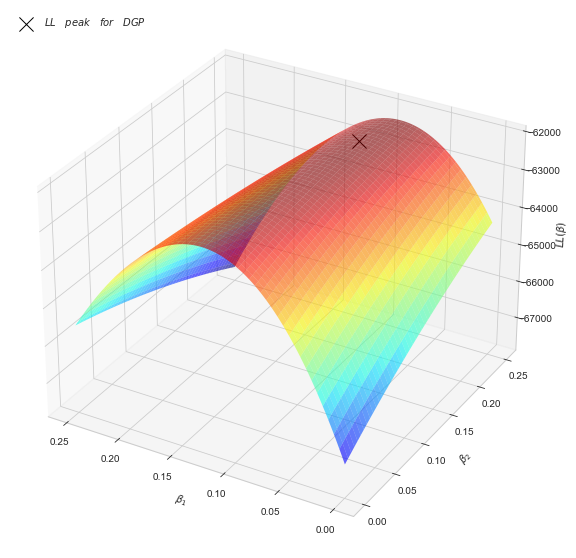

In [5]:
# a. Grids 
beta_vec = np.linspace(0,0.25,100)
beta1_grid,beta2_grid = np.meshgrid(beta_vec,beta_vec,indexing='ij')
LL_grid = log_likelihood([mp.beta[0], beta1_grid, beta2_grid], y_obs, x_obs)

# b. Main surface plot and value of log-likelihood function at data generating beta1 and beta2
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
surf = ax.plot_surface(beta1_grid,beta2_grid,LL_grid, alpha=0.6, cmap=cm.jet)
LL_scat = log_likelihood(mp.beta, y_obs, x_obs)
scatter = ax.scatter(mp.beta[1], mp.beta[2], LL_scat, marker="x", label=r'$LL\quad peak\quad for\quad DGP$', alpha=1, color='black', edgecolor='black', linewidths=1, s=200) #create scatter plot of data

# c. Add labels 
ax.set_xlabel(r'$\beta_1$')
ax.set_ylabel(r'$\beta_2$')
ax.set_zlabel(r'$LL(\beta)$')

# d. Adjust format
ax.invert_xaxis()
plt.legend(loc="upper left")
fig.set_size_inches(20,10)

**Question 3:** Estimate $\beta$ by maximum likelihood. You may use a gradient-free approach or gradients if you will. 

In [6]:
# a. Define Objective function to be minimized 
def obj(beta, y_obs, x_obs):
    LL = -log_likelihood(beta, y_obs, x_obs) # switch sign of LL function for maximization
    return LL

# b. Define initial guesses for betas
x0 = [0.1, 0.1, 0.1]

# c. Call solver and print results
result = optimize.minimize(obj,x0,args=(y_obs, x_obs),method='Nelder-Mead')

# d. Save betas and print result
beta = result.x
print(result)

 final_simplex: (array([[0.15168613, 0.0952903 , 0.20383104],
       [0.15162675, 0.09530445, 0.20382038],
       [0.15174268, 0.09529291, 0.20374044],
       [0.15170442, 0.09530387, 0.20378447]]), array([62232.93021453, 62232.93021539, 62232.93021577, 62232.93022559]))
           fun: 62232.93021453002
       message: 'Optimization terminated successfully.'
          nfev: 126
           nit: 70
        status: 0
       success: True
             x: array([0.15168613, 0.0952903 , 0.20383104])


**Question 4:** Based on your estimated parameters, simulate a choice `y_sim` pr individual in `x_obs`. Create an output table that shows following 4 statistics:   
The number of times where:
* `y_obs` = 1 and `y_sim` = 1
* `y_obs` = 1 and `y_sim` = 0
* `y_obs` = 0 and `y_sim` = 1
* `y_obs` = 0 and `y_sim` = 0 

Comment on the distribution of occurances across cells in the table.

In [7]:
# a. Simulate y values for all observed x
y_sim = np.zeros(y_obs.size)   # initiate numpy array of zeros
for i in range(len(x_obs)):    # loop over rows of x_obs
    if beta[0]+beta[1]*x_obs[i,1]+beta[2]*x_obs[i,2] > 0:    # if simulated value is above 0, set y_sim to 1
        y_sim[i] = 1

# b. Create data frame of observed and simulated y values
y_table = pd.DataFrame.from_dict({'y_obs': y_obs, 'y_sim': y_sim})

# c. Create columns with booleans for each statistic
y_table['stat1'] = (y_table.y_obs == 1) & (y_table.y_sim == 1)
y_table['stat2'] = (y_table.y_obs == 1) & (y_table.y_sim == 0)
y_table['stat3'] = (y_table.y_obs == 0) & (y_table.y_sim == 1)
y_table['stat4'] = (y_table.y_obs == 0) & (y_table.y_sim == 0)

# d. Count occurences where the conditions are fulfilled
stat1_count = y_table.stat1.sum()
stat2_count = y_table.stat2.sum()
stat3_count = y_table.stat3.sum()
stat4_count = y_table.stat4.sum()

# e. Create data frame of count of occurances
stat_dict = {}
for i in ['stat1_count','stat2_count','stat3_count','stat4_count']:
    stat_dict[i] = eval(i)    
stat_table = pd.DataFrame.from_dict(stat_dict, orient='index')

# f. Reset index, rename columns and entries, print data frame
stat_table.reset_index(level=0, inplace=True)
stat_table = stat_table.rename(columns={0: 'number of occurences','index':'statistic'})
stat_table['statistic'] = stat_table['statistic'].replace({'stat1_count': 'y_obs = 1 and y_sim = 1','stat2_count': 'y_obs = 1 and y_sim = 0', 'stat3_count':'y_obs = 0 and y_sim = 1','stat4_count': 'y_obs = 0 and y_sim = 0'})
print(stat_table.to_string(index=False))

              statistic  number of occurences
y_obs = 1 and y_sim = 1                 66908
y_obs = 1 and y_sim = 0                   375
y_obs = 0 and y_sim = 1                 32331
y_obs = 0 and y_sim = 0                   386


The distribution of occurances shows that the observed and the simulated y are both one. Results where both are zero ar less common. This distribution is expected, since even small positive deviations of simulated y values around zero can lead to their classification as one. The low number of occurances of cases where the simulated y value is zero underlines this observation.

**Question 5:** Test if your initial guess of $\beta$ will have an impact on the final estimate. Why do you think there is/is not an impact? 

In [8]:
# a. Create array of uniformly distributed random values for betas
np.random.seed(123)
x0s = 0 + 0.25*np.random.uniform(size=(5,3))

# b. Initiate empty arrays for estimates, function values, and optimal solution
xs = np.empty((5,3))
fs = np.empty(5)

# c. Loop over initial guesses, optimizing each using objective function defined above, save and print solutions
for i,x0 in enumerate(x0s):
    result = optimize.minimize(obj,x0,args=(y_obs, x_obs),method='Nelder-Mead')    
    xs[i,:] = result.x
    f = result.fun
    print(f'{i:4d}: x0 = ({x0[0]:6.2f},{x0[1]:6.2f},{x0[2]:6.2f})',end='')
    print(f' -> converged at ({xs[i][0]:6.2f},{xs[i][1]:6.2f},{xs[i][2]:6.2f}) with f = {f:.14f}')

   0: x0 = (  0.17,  0.07,  0.06) -> converged at (  0.15,  0.10,  0.20) with f = 62232.93021195355686
   1: x0 = (  0.14,  0.18,  0.11) -> converged at (  0.15,  0.10,  0.20) with f = 62232.93021505959041
   2: x0 = (  0.25,  0.17,  0.12) -> converged at (  0.15,  0.10,  0.20) with f = 62232.93021014222177
   3: x0 = (  0.10,  0.09,  0.18) -> converged at (  0.15,  0.10,  0.20) with f = 62232.93022415537416
   4: x0 = (  0.11,  0.01,  0.10) -> converged at (  0.15,  0.10,  0.20) with f = 62232.93021675550699


The initial guess of beta does not influence the final estimate. This is expected when looking at the graph of the log-likelihood function, which does not show local maxima.

# Consumption saving with borrowing

We are now considering the consumption-savings model with an extension: households may **borrow** money in the first period. Additionally, there are **2 kinds** of households: the first type will likely see a **low level** of period 2 income, whereas the second type will likely see a **high** second period income. 

A household lives for 2 periods and makes decisions on consumption and saving in each period.  

**Second period:**   
Solving the consumer problem in the second period is similar to the baseline case we have seen before.

The household gets utility from **consuming** and **leaving a bequest** (warm glow),

$$
\begin{aligned}
v_{2}(m_{2})&= \max_{c_{2}}\frac{c_{2}^{1-\rho}}{1-\rho}+\nu\frac{(a_2+\kappa)^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
a_2 &= m_2-c_2 \\
a_2 &\geq 0
\end{aligned}
$$

where
* $m_t$ is cash-on-hand 
* $c_t$ is consumption
* $a_t$ is end-of-period assets 
* $\rho > 1$ is the risk aversion coefficient
* $\nu > 0 $ is the strength of the bequest motive
* $\kappa > 0$ is the degree of luxuriousness in the bequest motive  
* $a_2\geq0$ ensures the household *cannot* die in debt

**First period:**   
The household gets utility from immediate consumption.  Household takes into account that next period income is stochastic.

$$
\begin{aligned}
v_1(m_1)&=\max_{c_1}\frac{c_{1}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{1}\left[v_2(m_2)\right]\\&\text{s.t.}&\\
a_1 & = m_1 - c_1 \\
m_2 & = (1+r)a_1 + y_2 \\
y_{2} & = \begin{cases}
1 - \Delta & \text{with prob. } P_{low}\\
1 + \Delta & \text{with prob. } P_{high} 
\end{cases}\\
a_1 & > -\frac{1-\Delta}{1+r} 
\end{aligned}
$$

where
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y_2$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk 
* $r$ is the interest rate
* $\frac{1-\Delta}{1+r} > c_1 - m_1$ ensures the household cannot borrow *more* than it will be able to repay in next period when $y_2$ is received.

The **2 types** of households are defined by their different $(P_{low},P_{high})$:
* Type 1: 
    * $P_{low} = 0.9$ 
    * $P_{high} = 0.1$
* Type 2:
    * $P_{low} = 0.1$ 
    * $P_{high} = 0.9$

In [9]:
# Imports and set magics

%load_ext autoreload
%autoreload 2

from types import SimpleNamespace

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import ConsumptionSaving as cs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Parameters
rho = 3
kappa = 0.5
nu = 0.1
r = 0.04
beta = 0.95
Delta = 0.5

# Income probability parameters
P1_low = 0.9
P1_high = 0.1
P2_low = 0.1
P2_low = 0.9

# Create a SimpleNamespace for each household type
from types import SimpleNamespace

# Create a SimpleNamespace for each households type
par_1 = SimpleNamespace()
par_1.rho = 3
par_1.kappa = 0.5
par_1.nu = 0.1
par_1.r = 0.04
par_1.beta = 0.95
par_1.Delta = 0.5
par_1.P_low = 0.9
par_1.P_high = 0.1

par_2 = SimpleNamespace()
par_2.rho = 3
par_2.kappa = 0.5
par_2.nu = 0.1
par_2.r = 0.04
par_2.beta = 0.95
par_2.Delta = 0.5
par_2.P_low = 0.1
par_2.P_high = 0.9

**Question 1** Solve the model for each type of household. Plot the value functions $v_1(m_1)$ and $v_2(m_2)$ in one graph for each household type. Comment on the differences.

In [11]:
# a. Call the ConsumptionSavingModel class
type1_model = cs.ConsumptionSavingModel(par_1)
type2_model = cs.ConsumptionSavingModel(par_2)


# b. Extract the optimal m1,v1,c1,m2,v2,c2 for each type

# i. Type 1
m1_type1,v1_type1,c1_type1,m2_type1,v2_type1,c2_type1 = type1_model.solve()

# ii. Type 2
m1_type2,v1_type2,c1_type2,m2_type2,v2_type2,c2_type2 = type2_model.solve()

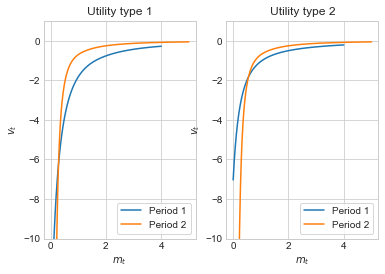

In [12]:
# Plot the optimal value functions

fig = plt.figure()

# Type 1 optimal value function
ax = fig.add_subplot(1,2,1)
ax.plot(m1_type1,v1_type1, label=f'Period {1}')
ax.plot(m2_type1,v2_type1, label=f'Period {2}')
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_t$')
ax.set_ylabel('$v_t$')
ax.set_title('Utility type 1')
ax.set_ylim([-10,1]);

# Type 2 optimal value function
ax = fig.add_subplot(1,2,2)
ax.plot(m1_type2,v1_type2, label=f'Period {1}')
ax.plot(m2_type2,v2_type2, label=f'Period {2}')
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_t$')
ax.set_ylabel('$v_t$')
ax.set_title('Utility type 2')
ax.set_ylim([-10,1]);

In period 2, the utility functions are identical for both types for a given level of period 2 cash-on-hand. This is because the two types only differ with respect to their probability to earn high or low income in period 2, which only influences their optimal choice in period 2 (as there is no uncertainty anymore in period 2). However, the household types differ with respect to their utility in period 1. For any given level of period 1 cash-on-hand, type 2 households have a higher utility than type 2 households. This is because type 2 households are more likely to earn high earnings in period 2 than type 1 households, and therefore can increase their utility by borrowing money in period 1.

**Question 2** From the model solution, obtain the optimal consumption functions $c_1^*(m_1)$ and $c_2^*(m_2)$. Plot these in one graph for each type of household. Comment on the observed differences between household types. 

 **Note:** We have already extracted the optimal consumption levels from the class. Hence, we can simply plot the solutions.

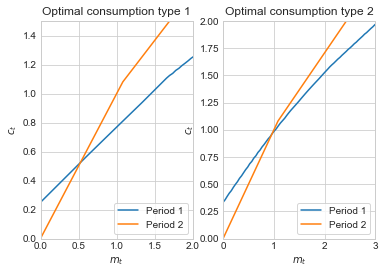

In [13]:
# Plot the optimal consumption functions

fig = plt.figure()

# Type 1 optimal consumption function
ax = fig.add_subplot(1,2,1)
ax.plot(m1_type1,c1_type1, label=f'Period {1}')
ax.plot(m2_type1,c2_type1, label=f'Period {2}')
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$')
ax.set_title('Optimal consumption type 1')
ax.set_xlim([0,2])
ax.set_ylim([0,1.5]);

# Type 2 optimal consumption function
ax = fig.add_subplot(1,2,2)
ax.plot(m1_type2,c1_type2, label=f'Period {1}')
ax.plot(m2_type2,c2_type2, label=f'Period {2}')
ax.legend(loc='lower right',facecolor='white',frameon=True)
ax.set_xlabel('$m_t$')
ax.set_ylabel('$c_t$')
ax.set_title('Optimal consumption type 2')
ax.set_xlim([0,3])
ax.set_ylim([0,2]);

Again, we can see that the optimal level of consumption in period 2 is identical for both types. This is because there is no uncertainty in period 2. Still, type 2's consumption levels in period 1 exceed type 1's consumption levels in period 1 for any given level of period 1 cash-on-hand. This is because, type 2 expects higher earnings (in probability) than type 1 and therefore it is optimal from them to borrow in period 1 in order to increase their immediate consumption level.

**Question 3** Simulate `simN` households of each type based on the distribution of $m_1$ below. You can use the same distribution for both household types. What is the fraction of households who *borrow* in period 1, $c_1 > m_1$, in each group?

In [14]:
np.random.seed(2021)
simN = 1000
# No one gets negative m in first period
sim_m1 = np.fmax(np.random.normal(1, 1, size = simN), 0) 

In [15]:
# a. We simulate data based on the true model
type1_model.sim_m1 = sim_m1 
type2_model.sim_m1 = sim_m1

# b. We simulate optimal c1 and c2 levels for both types based on initial cash-on-hand
data_c1_type1 = type1_model.simulate() 
data_c1_type2 = type2_model.simulate()

# c. Determine when consumption in period 1 is greater than cash-on-hand in period 1
type_1 = data_c1_type1>type1_model.sim_m1 # for type 1
type_2 = data_c1_type2>type2_model.sim_m1 # for type 2

# d. Calculate the fraction of households who borrow in period 1 for type1 and type 2, respectively
fraction1, fraction2 = sum(i == True for i in type_1)/simN, sum(i == True for i in type_2)/simN
print(f' The fraction of type 1 households who borrow in period 1 is {fraction1*100:.3f} percent \n The fraction of type 2 households who borrow in period 1 is {fraction2*100:.3f} percent')

 The fraction of type 1 households who borrow in period 1 is 33.900 percent 
 The fraction of type 2 households who borrow in period 1 is 49.000 percent


# Division by Newton's method

One can obtain the numerical ratio of 2 real numbers **using only multiplication** and harnessing Newton's method! This may be helpful when the numbers are very large because division methods of large numbers is costly.  

Our objective is to find the numerical $x$ 
$$
x = \frac{n}{d}
$$
given the two numbers $n,d$. 

**First note** that if we can find the numeric value $\tilde{d}$ 
$$
\tilde{d} = \frac{1}{d}
$$
then we can readily obtain $x$ by 
$$
x = n \times \tilde{d}
$$

Therefore, our objective comes down to finding the value of $\tilde{d}$ and the rest is trivial.

**Second, note** that Newton's method can be used to find the root $x^*$ of a function $f(x)$ by the iteration steps

$$
x_{k+1} = x_{k} - \frac{f(x_{k})}{f^{\prime}(x_{k})} \equiv \mathcal{N}(x_k) 
$$

This means that if we can define some function $f(x)$ such that 
$$
f(x) = 0 \Leftrightarrow x = \frac{1}{d}
$$
then the root $x^*$ provides us with the numerical value that we want.

**Third, note** that the function $g(x)$
$$
g(x) = \frac{1}{x}-d
$$
has the property $g(\tilde{d}) = 0$, which means that $g(x)$ is a good candidate for $f(x)$.


**Question 1:** By applying the function $g(x)$ in Newton's method, we can avoid any use of division during the run of the algorithm.   
Derive the expression $\frac{g(x)}{g'(x)}$. Do you see why there is no division involved?

In [16]:
import sympy as sm
from sympy import * # required for the expand method

# a. Define symbols
x = sm.symbols('x')
d = sm.symbols('d')
gx = sm.symbols('g(x)')

# b. Define function g(x)
g = 1/x - d
g

-d + 1/x

In [17]:
# c. Define the differential with respect to x
g_diff = sm.diff(g,x)
g_diff

-1/x**2

In [18]:
# d. Derive expression g(x)/g'(x)
expression = expand(g/g_diff)
deriv =  Derivative(gx, x)
Eq(gx/deriv,expression)

Eq(g(x)/Derivative(g(x), x), d*x**2 - x)

There's no division involved, because the denominator in the first derivative cancels out when dividing g(x) by g'(x).

**Question 2:** Implement the algorithm below in code and test it. 

<font size="4">Division algorithm</font>
1. Choose a tolerance level $\epsilon > 0$. Provide an initial guess $\tilde{d}_0$. Set $k = 0$.
2. Calculate $g(\tilde{d}_k)$.
3. If $|g(\tilde{d}_k)| < \epsilon$ then stop and return $x = n \times \tilde{d}_k$.
4. Calculate a new candidate root $\tilde{d}_{k+1} = \mathcal{N}(\tilde{d}_k)$. 
5. Set $k = k + 1$ and return to step 2.

**Important:** if the starting point $\tilde{d}_0$ is too far off target, then you might not get convergence.   
You can test your implementation with the example:   
$n$ = 37.581    
$d$ = 5.9   
$\tilde{d}_0$ = 0.2

In [19]:
# Translate SymPy expressions into Python functions
g_func = sm.lambdify((x,d),g) 
g_diff = sm.lambdify(x,g_diff)

In [20]:
def newton_division(g_func,g_diff,n, d, d0=0.2, max_iter=500, tol=1e-8):
    
    """ Obtaining the numerical ratio fo two real number with the Newton's method
    
    Args:
        g_func (callable): function
        g_diff (callable): derivative
        n (float,optional): constant
        d (float,optional): constant
        d0 (np.ndarray): initial guess
        max_iter (int,optional): maximum number of iterations     
        tol (float,optional): tolerance
    
    Returns
        x (np.array): numerical value of of ratio of two real numbers (n/d)
        k (int): number of iterations used
    """
    
    # initialize
    d_tildek = d0
    k = 0
   
    # Step 1: set a tolerance level and initial guess
    tol = 1e-8
    d0 = 0.2
    
    
    while k < max_iter:
        
        # Define x as a function of n and d_tilkdek
        x = n*d_tildek
        
        # Step 2: calculate g(d_tildek)
        result = g_func(d_tildek,d)
        
        # Step 3: stop if absolite values are below tolerance level
        if abs(result) < tol:
            break
            
        # Step 4: calculate a new candidate root
        else:
            d_tildek = d_tildek - g_func(d_tildek,d)/g_diff(d_tildek)
                   
        # Step 5: set k = k+1
        k += 1
        
    return k, x
        

In [21]:
# Test the implementation with the parameter values given in the example
newton_division(g_func,g_diff,n=37.581, d=5.9, d0=0.2, max_iter=500, tol=1e-8)

(4, 6.369661016941417)

In [22]:
# Test if result is correct
37.581/5.9

6.369661016949153

The algorithm returns the desired results, i.e., x = n/d. Hence, division by Newton's method can be applied to obtain the numerical ratio of 2 real numbers only with multiplication.